<a href="https://colab.research.google.com/github/Deepak-1257/DailyNews-App/blob/main/Air_quality_prediction_major.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime

import math
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import Dense, LSTM



In [3]:
# Set random seed
tf.random.set_seed(42)
from google.colab import files
uploaded = files.upload()



Saving air-quality-india.csv to air-quality-india.csv


In [4]:
# Load data from ThingSpeak
df = pd.read_csv('air-quality-india.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36192 entries, 0 to 36191
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  36192 non-null  object 
 1   Year       36192 non-null  int64  
 2   Month      36192 non-null  int64  
 3   Day        36192 non-null  int64  
 4   Hour       36192 non-null  int64  
 5   PM2.5      36192 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.7+ MB


In [6]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

In [8]:
df.head()

,date,time,temperature,humidity,pressure,air_quality_index
0,2022-01-01,00:00:00,21,60,1013,50
1,2022-01-01,01:00:00,20,55,1014,48
2,2022-01-01,02:00:00,19,50,1015,45
3,2022-01-01,03:00:00,18,45,1016,43
4,2022-01-01,04:00:00,17,40,1017,40


In [7]:
df['Date']=df["Timestamp"].dt.date

In [13]:
df_time=pd.DataFrame(df.groupby('time')['air_quality_index'].mean())
df_time

,air_quality_index
time,
00:00:00,50.0
01:00:00,48.0
02:00:00,45.0
03:00:00,43.0
04:00:00,40.0
05:00:00,38.0
06:00:00,35.0
07:00:00,33.0
08:00:00,30.0


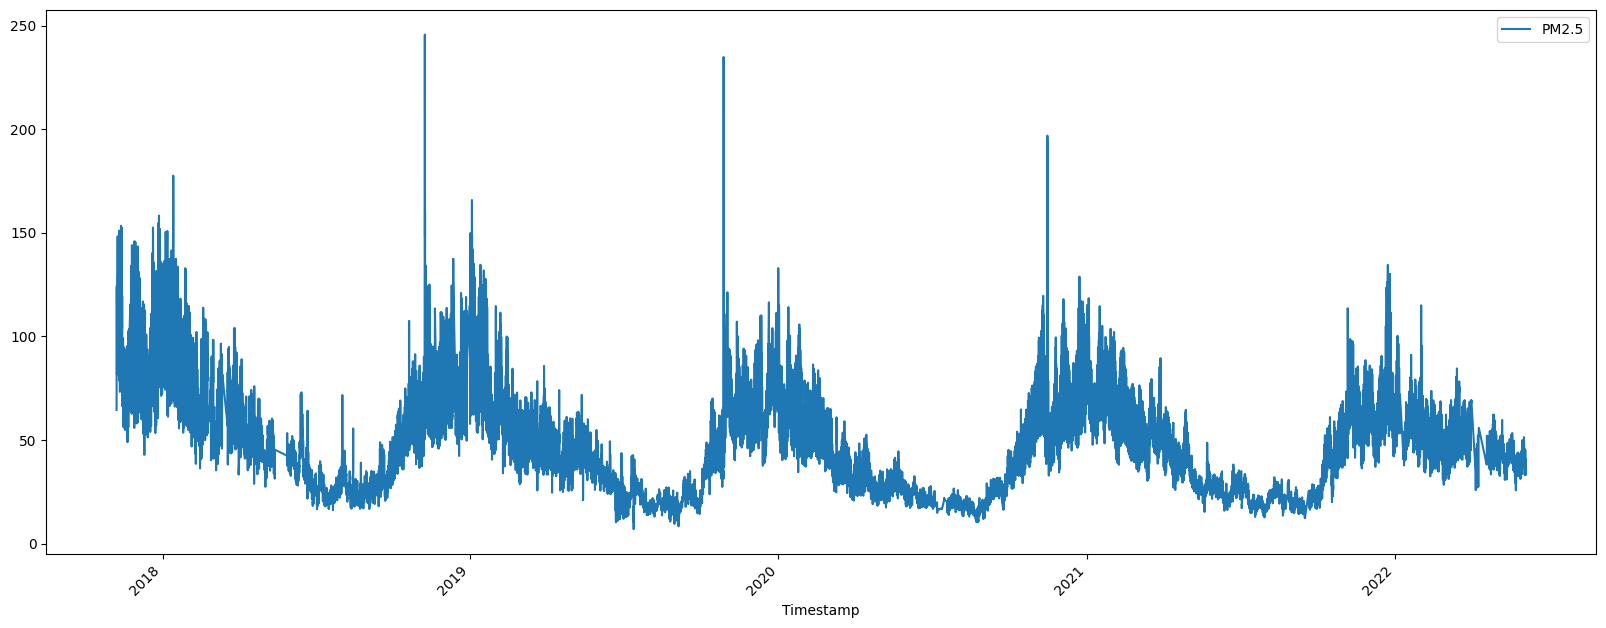

In [8]:
df.plot(x='Timestamp',y='PM2.5',figsize=(20,8))
plt.xticks(rotation=45)

plt.show()

<Axes: xlabel='Year'>

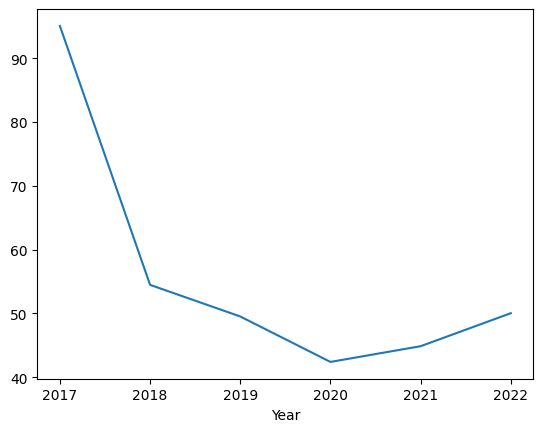

In [10]:
df.groupby('Year')['PM2.5'].mean().plot()

<Axes: xlabel='Month'>

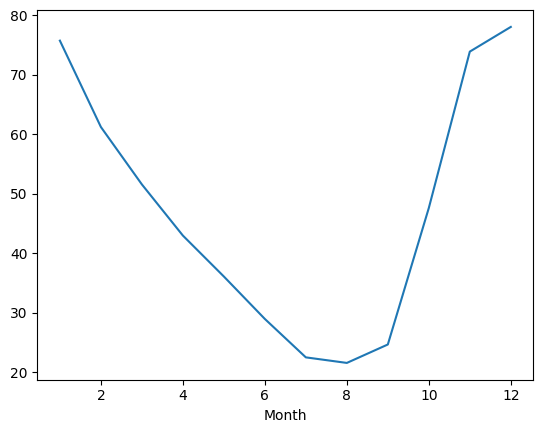

In [11]:
df.groupby('Month')['PM2.5'].mean().plot()

<Axes: xlabel='Hour'>

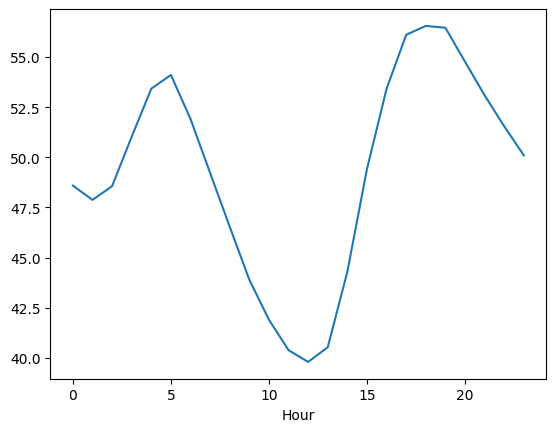

In [12]:
df.groupby('Hour')['PM2.5'].mean().plot()

In [13]:
df_date=pd.DataFrame(df.groupby('Date')['PM2.5'].mean())
df_date

,PM2.5
Date,
2017-11-07,99.805833
2017-11-08,110.979565
2017-11-09,114.915833
2017-11-10,119.404091
2017-11-11,109.267273
...,...
2022-05-31,41.465417
2022-06-01,41.645833
2022-06-02,42.255417


<Axes: xlabel='Date'>

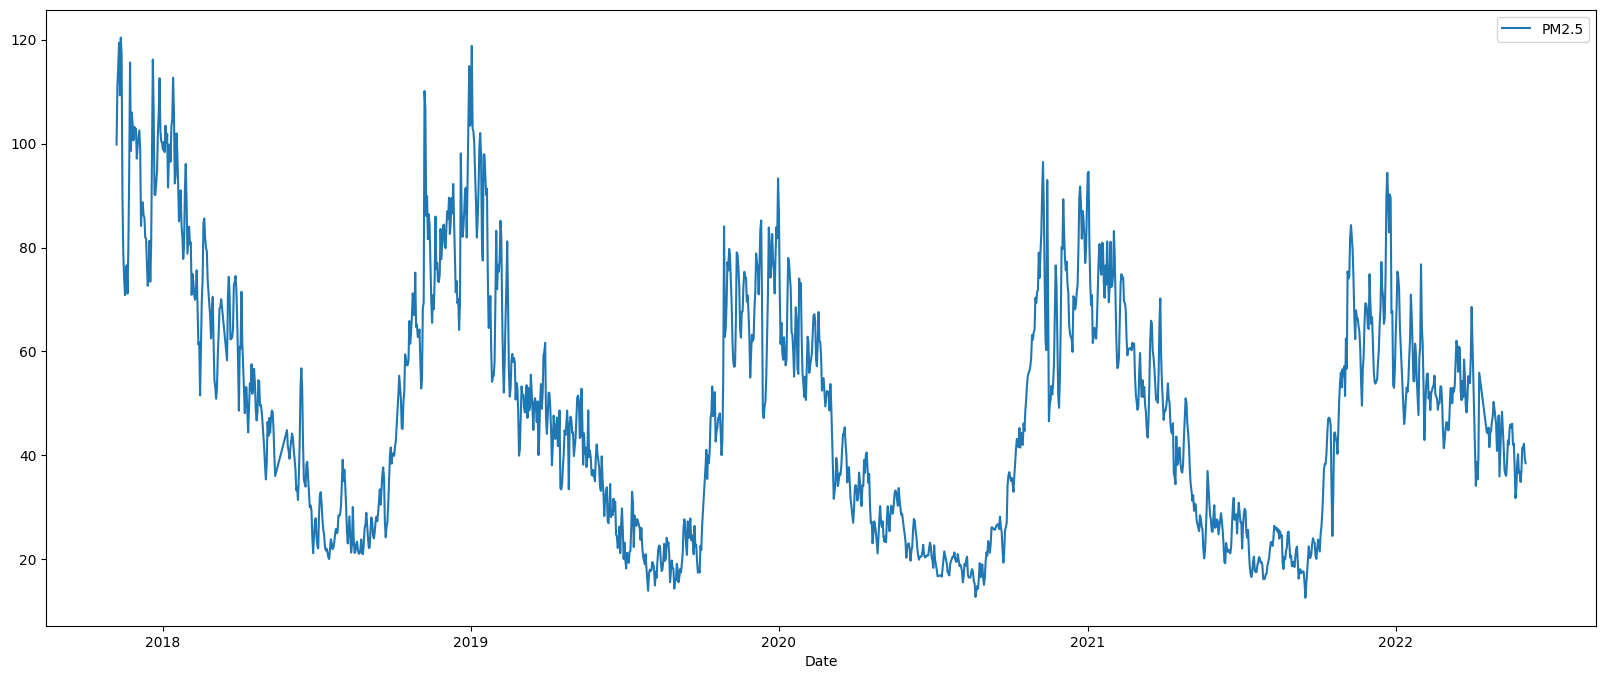

In [15]:
df_date.plot(figsize=(20,8))

In [16]:
dataset  = df_date.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1293

In [17]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
scaled_data

array([[0.80924161],
       [0.91297267],
       [0.94951492],
       ...,
       [0.27497376],
       [0.24870153],
       [0.24014526]])

In [19]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
num = 60
for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])

In [20]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1233, 60, 1)

In [23]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [24]:
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [25]:
model.fit(x_train,y_train, batch_size=1, epochs=1)

1233/1233 [==============================] - 29s 21ms/step - loss: 0.0068


In [26]:
test_data = scaled_data[training_data_len-60: , :]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])

In [28]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [29]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

11/11 [==============================] - 1s 13ms/step


In [30]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.3953684750024922

In [31]:
train = df_date[:training_data_len]
valid = df_date[training_data_len:]
valid["Predictions"] = predictions
valid

,PM2.5,Predictions
Date,,
2021-06-28,28.667917,27.697956
2021-06-29,30.903750,27.669920
2021-06-30,29.017917,28.412231
2021-07-01,27.166667,28.743996
2021-07-02,27.132917,28.448307
...,...,...
2022-05-31,41.465417,36.367439
2022-06-01,41.645833,37.548420
2022-06-02,42.255417,38.771942


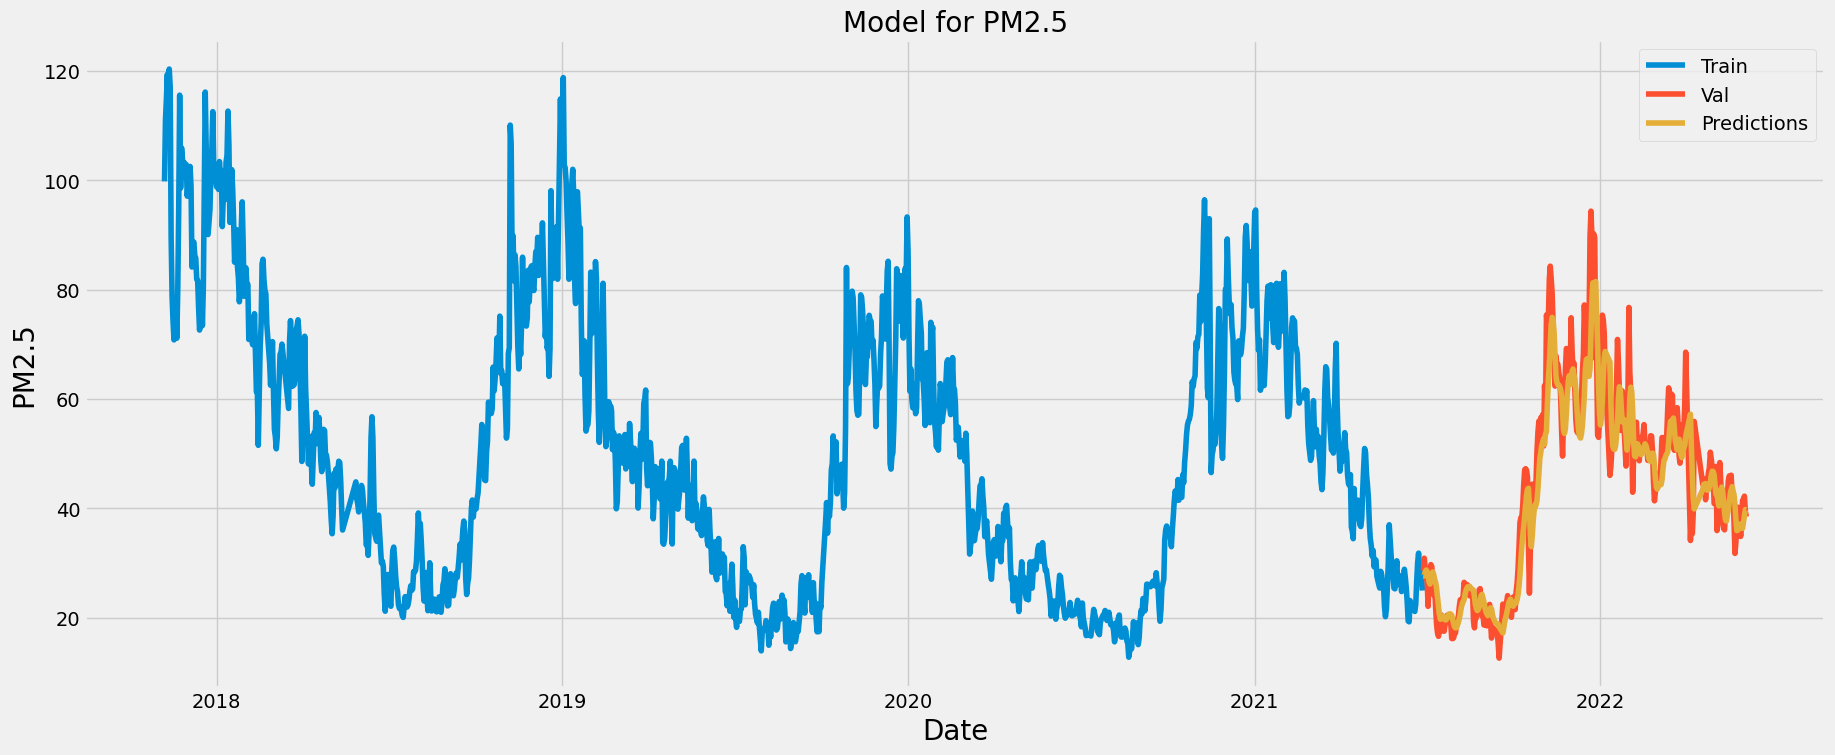

In [34]:
plt.figure(figsize=(20,8))
plt.title("Model for PM2.5")
plt.xlabel("Date", fontsize = 20)
plt.ylabel("PM2.5",fontsize=20)
plt.plot(train[df_date.columns])
plt.plot(valid['PM2.5'])
plt.plot(valid["Predictions"])
plt.legend(["Train","Val","Predictions"])